In [1]:
import os , csv ,multiprocessing , configparser
from tools.import_data import *
from pathlib import Path, PureWindowsPath
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from sklearn import model_selection

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer # for NaN values
import pandas
import matplotlib.pyplot as plt

In [3]:
#Selecting Models
models = []
    
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [4]:
def train_the_data(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    scoring = 'accuracy'
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        scores.append(cv_results)
        names.append(name)
        results.append({"name":name,"score":cv_results.mean()})
        # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        # print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return results
        
def test_the_data(X_train,Y_train,X_test,Y_test,models):
    # Make predictions on test dataset
    results = []
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        # print('Model ' , name)
        # print('Accuracy: ', accuracy_score(Y_test, predictions))
        results.append({"name":name,"score":accuracy_score(Y_test, predictions)})
        #print(confusion_matrix(Y_validation, predictions))
        # print(classification_report(Y_test, predictions))
    return results 
    # 
    # encoder(predict_dataset)
    # #print (predict_dataset)
    # predict=predict_dataset.values[:,0:22]
    # 
    # predictions = lr.predict(predict)
    
    # temp = pandas.DataFrame(predict)
    # temp['class'] = predictions
    # temp.to_csv('predict.csv')
def get_the_best(results): # input - list of dict {"name":name,"score":score}
    m = max([k["score"] for k in results])
    i = [k["score"] for k in results].index(m)
    name = results[i]["name"]
    printmd('The best model for the given data is: <span style="color:green">' + str(name).format() + '</span> with the score <span style="color:green">' + str(m) + '</span>' )
    # print ('The best model for the given train (' + X_train.shape +') is: ' + name + 'with the score ' +m )
    return results[i] # the max model (dict type)

# def information_gain(X, y):
#     def _entropy(labels):
#         counts = np.bincount(labels)
#         return entropy(counts, base=None)
# 
#     def _ig(x, y):
#         # indices where x is set/not set
#         x_set = np.nonzero(x)[1]
#         x_not_set = np.delete(np.arange(x.shape[1]), x_set)
# 
#         h_x_set = _entropy(y[x_set])
#         h_x_not_set = _entropy(y[x_not_set])
# 
#         return entropy_full - (((len(x_set) / f_size) * h_x_set)
#                              + ((len(x_not_set) / f_size) * h_x_not_set))
# 
#     entropy_full = _entropy(y)
# 
#     f_size = float(X.shape[0])
# 
#     scores = np.array([_ig(x, y) for x in X.T])
#     return scores

In [5]:
#consts
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CONFIG_FILE = '{}/config.ini'.format(FILE_PATH)
config = configparser.ConfigParser()
config.read(CONFIG_FILE)
TRAIN_FILE = str(config['files']['train_set'])
TEST_FILE = str(config['files']['test_set'])
if __name__ == "__main__":
    X_train, Y_train ,names_train = load_dataset(TRAIN_FILE)    
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    if TEST_FILE:
        X_test, Y_test ,names_test = load_dataset(TEST_FILE)
        print ('Test data shape: ', X_test.shape)
        print ('Test labels shape: ', Y_test.shape)

Train data shape:  (776, 51)
Train labels shape:  (776,)


In [6]:
    # Create our imputer to replace missing values with the mean e.g.
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp = imp.fit(X_train)
    X_train_imp = imp.transform(X_train)
    print(fs.mutual_info_classif(X_train_imp,Y_train))
    # print(information_gain(X_train_imp,Y_train))

[0.02254245 0.03725804 0.03300929 0.03288793 0.06968308 0.01205639
 0.06509242 0.01973039 0.0082967  0.00267455 0.04051225 0.0478854
 0.         0.00418009 0.02898567 0.         0.07789978 0.05911982
 0.03208112 0.08461556 0.         0.04108854 0.0566051  0.05863615
 0.07875955 0.14417484 0.115296   0.00985331 0.         0.06891575
 0.05587499 0.09050992 0.08880455 0.06753803 0.09401631 0.01575821
 0.01162169 0.         0.02155347 0.         0.         0.
 0.         0.00561203]


In [16]:
    #before we found the elbow
    new_trains = []
    new_shapes_ratio = []
    new_range = []
    myrange = np.arange(0.01, 1, 0.01)
    for VTHRESH in myrange:  
        # sel = fs.VarianceThreshold(VTHRESH)
        sel = fs.SelectPercentile(score_func=fs.mutual_info_classif,percentile=VTHRESH*100)
        X_train_mod = sel.fit_transform(X_train_imp,Y_train)
        if len(new_shapes_ratio) >= 1:
            if new_shapes_ratio[-1]!= X_train_mod.shape[-1]/X_train.shape[-1]:
                new_range.append(VTHRESH)
                new_trains.append(X_train_mod)
                new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
        else:
            new_range.append(VTHRESH)
            new_trains.append(X_train_mod)
            new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
        


**Training Section** for: 1 features

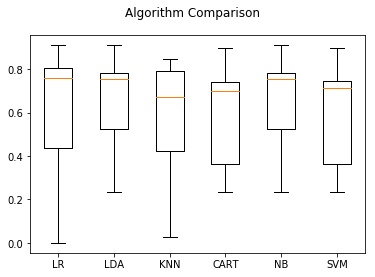

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.6574425574425574</span>

{'name': 'LR', 'score': 0.6183982683982685}
{'name': 'LDA', 'score': 0.6574425574425574}
{'name': 'KNN', 'score': 0.5682817182817183}
{'name': 'CART', 'score': 0.5942057942057943}
{'name': 'NB', 'score': 0.6548784548784549}
{'name': 'SVM', 'score': 0.5967865467865469}


**Training Section** for: 2 features

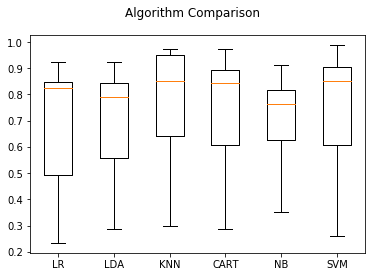

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.7642191142191141</span>

{'name': 'LR', 'score': 0.6933566433566434}
{'name': 'LDA', 'score': 0.7025807525807526}
{'name': 'KNN', 'score': 0.7642191142191141}
{'name': 'CART', 'score': 0.7475191475191475}
{'name': 'NB', 'score': 0.7028138528138529}
{'name': 'SVM', 'score': 0.7475191475191475}


**Training Section** for: 3 features

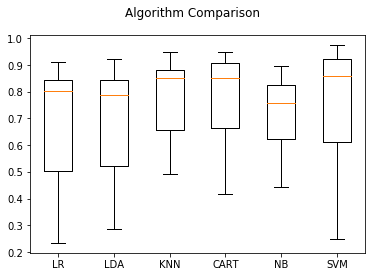

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.7686147186147185</span>

{'name': 'LR', 'score': 0.6831168831168831}
{'name': 'LDA', 'score': 0.6948384948384948}
{'name': 'KNN', 'score': 0.7686147186147185}
{'name': 'CART', 'score': 0.7658674658674658}
{'name': 'NB', 'score': 0.7119214119214121}
{'name': 'SVM', 'score': 0.7500666000666001}


**Training Section** for: 4 features

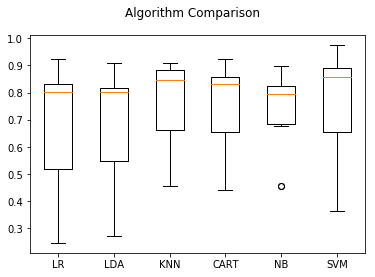

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.7646520146520146</span>

{'name': 'LR', 'score': 0.6856809856809858}
{'name': 'LDA', 'score': 0.6935564435564435}
{'name': 'KNN', 'score': 0.7646520146520146}
{'name': 'CART', 'score': 0.744039294039294}
{'name': 'NB', 'score': 0.7274558774558774}
{'name': 'SVM', 'score': 0.7645021645021645}


**Training Section** for: 5 features

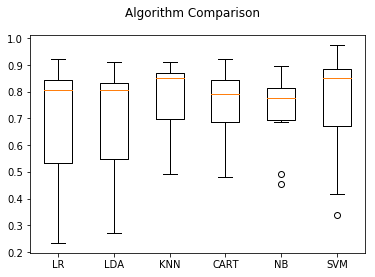

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.7712121212121212</span>

{'name': 'LR', 'score': 0.6882450882450882}
{'name': 'LDA', 'score': 0.6986846486846486}
{'name': 'KNN', 'score': 0.7712121212121212}
{'name': 'CART', 'score': 0.7415750915750916}
{'name': 'NB', 'score': 0.7249417249417249}
{'name': 'SVM', 'score': 0.7541958041958042}


**Training Section** for: 6 features

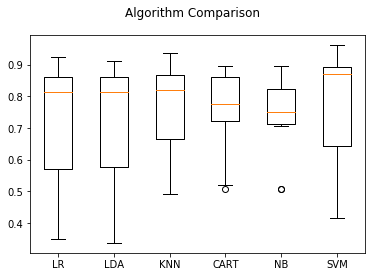

The best model for the given data is: <span style="color:green">SVM</span> with the score <span style="color:green">0.7606560106560106</span>

{'name': 'LR', 'score': 0.7167332667332668}
{'name': 'LDA', 'score': 0.7167832167832168}
{'name': 'KNN', 'score': 0.7544955044955045}
{'name': 'CART', 'score': 0.752047952047952}
{'name': 'NB', 'score': 0.7315184815184816}
{'name': 'SVM', 'score': 0.7606560106560106}


**Training Section** for: 7 features

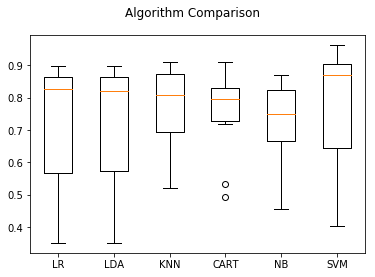

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.7635697635697636</span>

{'name': 'LR', 'score': 0.7180652680652682}
{'name': 'LDA', 'score': 0.7155178155178156}
{'name': 'KNN', 'score': 0.7635697635697636}
{'name': 'CART', 'score': 0.7533466533466534}
{'name': 'NB', 'score': 0.7147685647685647}
{'name': 'SVM', 'score': 0.7632201132201132}


**Training Section** for: 8 features

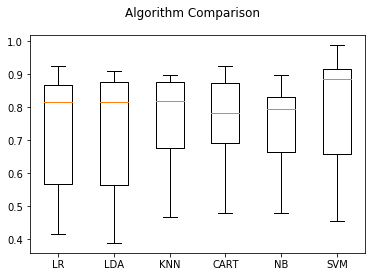

The best model for the given data is: <span style="color:green">SVM</span> with the score <span style="color:green">0.7864635364635364</span>

{'name': 'LR', 'score': 0.734915084915085}
{'name': 'LDA', 'score': 0.7310522810522809}
{'name': 'KNN', 'score': 0.7557942057942058}
{'name': 'CART', 'score': 0.7480186480186479}
{'name': 'NB', 'score': 0.7366300366300366}
{'name': 'SVM', 'score': 0.7864635364635364}


**Training Section** for: 9 features

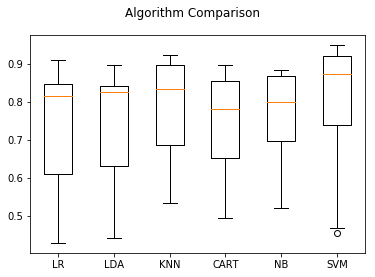

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.7882450882450882</span>

{'name': 'LR', 'score': 0.7362803862803864}
{'name': 'LDA', 'score': 0.7414585414585415}
{'name': 'KNN', 'score': 0.7882450882450882}
{'name': 'CART', 'score': 0.7391275391275391}
{'name': 'NB', 'score': 0.7677156177156178}
{'name': 'SVM', 'score': 0.7878954378954378}


**Training Section** for: 10 features

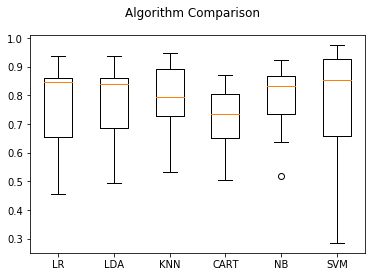

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7882783882783884</span>

{'name': 'LR', 'score': 0.7659340659340659}
{'name': 'LDA', 'score': 0.7750582750582751}
{'name': 'KNN', 'score': 0.7765068265068265}
{'name': 'CART', 'score': 0.7147352647352647}
{'name': 'NB', 'score': 0.7882783882783884}
{'name': 'SVM', 'score': 0.7514985014985014}


**Training Section** for: 11 features

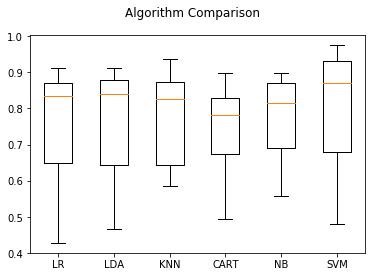

The best model for the given data is: <span style="color:green">SVM</span> with the score <span style="color:green">0.7955377955377955</span>

{'name': 'LR', 'score': 0.753046953046953}
{'name': 'LDA', 'score': 0.7582251082251081}
{'name': 'KNN', 'score': 0.7739760239760239}
{'name': 'CART', 'score': 0.7365800865800866}
{'name': 'NB', 'score': 0.7702131202131202}
{'name': 'SVM', 'score': 0.7955377955377955}


**Training Section** for: 12 features

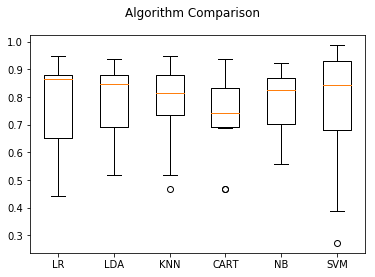

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7840825840825841</span>

{'name': 'LR', 'score': 0.7761904761904762}
{'name': 'LDA', 'score': 0.7840825840825841}
{'name': 'KNN', 'score': 0.7711788211788212}
{'name': 'CART', 'score': 0.7248584748584748}
{'name': 'NB', 'score': 0.7766233766233765}
{'name': 'SVM', 'score': 0.7578921078921078}


**Training Section** for: 13 features

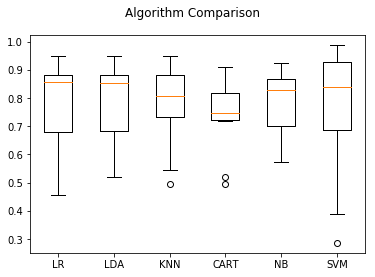

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7853479853479854</span>

{'name': 'LR', 'score': 0.7852647352647352}
{'name': 'LDA', 'score': 0.7853479853479854}
{'name': 'KNN', 'score': 0.773809523809524}
{'name': 'CART', 'score': 0.733982683982684}
{'name': 'NB', 'score': 0.7818181818181819}
{'name': 'SVM', 'score': 0.7592074592074591}


**Training Section** for: 14 features

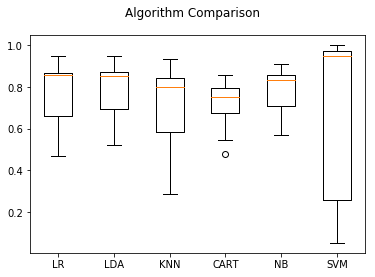

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7843989343989344</span>

{'name': 'LR', 'score': 0.7723276723276722}
{'name': 'LDA', 'score': 0.7827672327672328}
{'name': 'KNN', 'score': 0.6999000999000999}
{'name': 'CART', 'score': 0.7172827172827172}
{'name': 'NB', 'score': 0.7843989343989344}
{'name': 'SVM', 'score': 0.6846320346320345}


**Training Section** for: 15 features

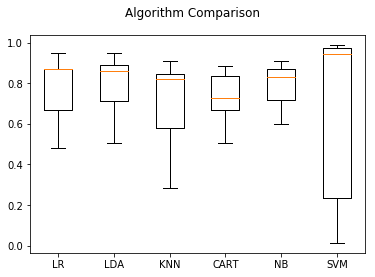

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7947219447219447</span>

{'name': 'LR', 'score': 0.7839660339660339}
{'name': 'LDA', 'score': 0.7905427905427905}
{'name': 'KNN', 'score': 0.7063769563769563}
{'name': 'CART', 'score': 0.724958374958375}
{'name': 'NB', 'score': 0.7947219447219447}
{'name': 'SVM', 'score': 0.6639194139194139}


**Training Section** for: 16 features

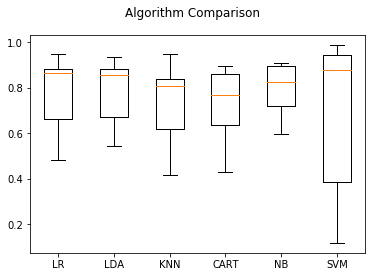

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7972693972693972</span>

{'name': 'LR', 'score': 0.7788045288045288}
{'name': 'LDA', 'score': 0.7904928404928404}
{'name': 'KNN', 'score': 0.7284881784881785}
{'name': 'CART', 'score': 0.7287046287046287}
{'name': 'NB', 'score': 0.7972693972693972}
{'name': 'SVM', 'score': 0.6940392940392941}


**Training Section** for: 17 features

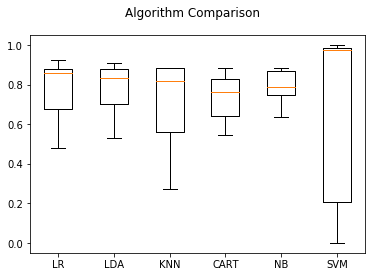

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7935397935397936</span>

{'name': 'LR', 'score': 0.7814851814851814}
{'name': 'LDA', 'score': 0.7841991341991343}
{'name': 'KNN', 'score': 0.7075591075591074}
{'name': 'CART', 'score': 0.7353479853479852}
{'name': 'NB', 'score': 0.7935397935397936}
{'name': 'SVM', 'score': 0.6728271728271729}


**Training Section** for: 18 features

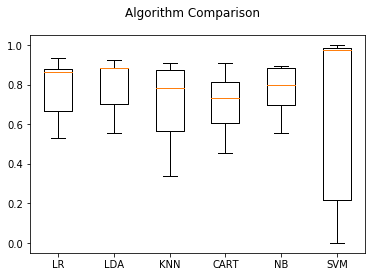

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7957209457209456</span>

{'name': 'LR', 'score': 0.784032634032634}
{'name': 'LDA', 'score': 0.7957209457209456}
{'name': 'KNN', 'score': 0.7076590076590077}
{'name': 'CART', 'score': 0.7081252081252081}
{'name': 'NB', 'score': 0.783083583083583}
{'name': 'SVM', 'score': 0.6728438228438229}


**Training Section** for: 19 features

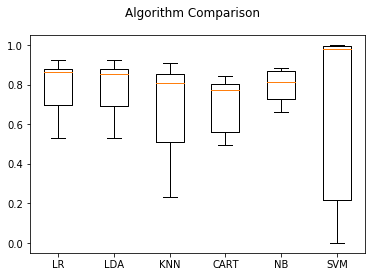

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7948051948051947</span>

{'name': 'LR', 'score': 0.7866799866799867}
{'name': 'LDA', 'score': 0.7867465867465868}
{'name': 'KNN', 'score': 0.683016983016983}
{'name': 'CART', 'score': 0.7003996003996005}
{'name': 'NB', 'score': 0.7948051948051947}
{'name': 'SVM', 'score': 0.677988677988678}


**Training Section** for: 20 features

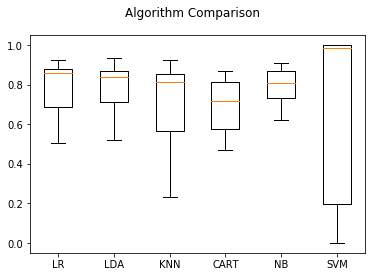

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7947885447885448</span>

{'name': 'LR', 'score': 0.7840659340659341}
{'name': 'LDA', 'score': 0.7841158841158842}
{'name': 'KNN', 'score': 0.7062770562770563}
{'name': 'CART', 'score': 0.6952880452880452}
{'name': 'NB', 'score': 0.7947885447885448}
{'name': 'SVM', 'score': 0.6753579753579754}


**Training Section** for: 21 features

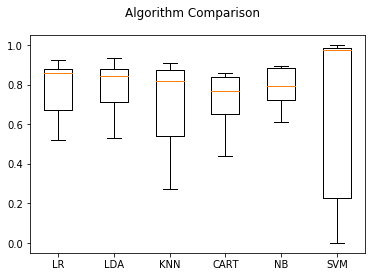

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7934731934731934</span>

{'name': 'LR', 'score': 0.784082584082584}
{'name': 'LDA', 'score': 0.7931734931734933}
{'name': 'KNN', 'score': 0.7062604062604062}
{'name': 'CART', 'score': 0.7223276723276724}
{'name': 'NB', 'score': 0.7934731934731934}
{'name': 'SVM', 'score': 0.6754412254412255}


**Training Section** for: 22 features

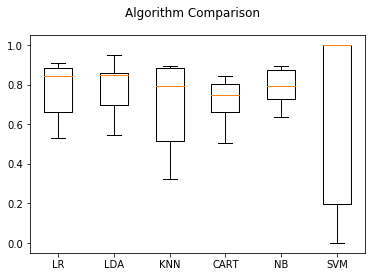

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7896603396603397</span>

{'name': 'LR', 'score': 0.7776390276390277}
{'name': 'LDA', 'score': 0.7879620379620379}
{'name': 'KNN', 'score': 0.6985181485181485}
{'name': 'CART', 'score': 0.7134532134532134}
{'name': 'NB', 'score': 0.7896603396603397}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 23 features

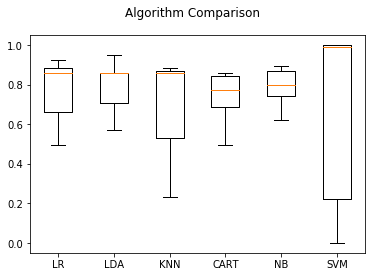

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7948551448551449</span>

{'name': 'LR', 'score': 0.7763403263403263}
{'name': 'LDA', 'score': 0.7919580419580419}
{'name': 'KNN', 'score': 0.6997169497169498}
{'name': 'CART', 'score': 0.7352980352980353}
{'name': 'NB', 'score': 0.7948551448551449}
{'name': 'SVM', 'score': 0.6818348318348318}


**Training Section** for: 24 features

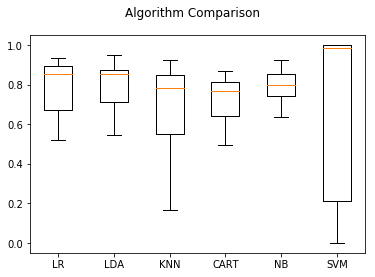

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7947718947718948</span>

{'name': 'LR', 'score': 0.7802197802197803}
{'name': 'LDA', 'score': 0.7919247419247419}
{'name': 'KNN', 'score': 0.6804861804861805}
{'name': 'CART', 'score': 0.7236763236763236}
{'name': 'NB', 'score': 0.7947718947718948}
{'name': 'SVM', 'score': 0.6792540792540793}


**Training Section** for: 25 features

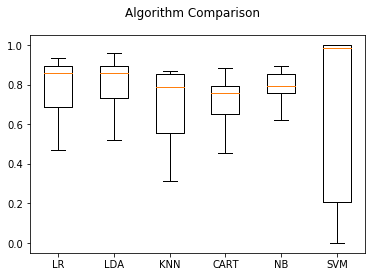

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7944222444222445</span>

{'name': 'LR', 'score': 0.7814185814185814}
{'name': 'LDA', 'score': 0.7944222444222445}
{'name': 'KNN', 'score': 0.6895937395937397}
{'name': 'CART', 'score': 0.7107725607725607}
{'name': 'NB', 'score': 0.7910422910422911}
{'name': 'SVM', 'score': 0.6766566766566766}


**Training Section** for: 26 features

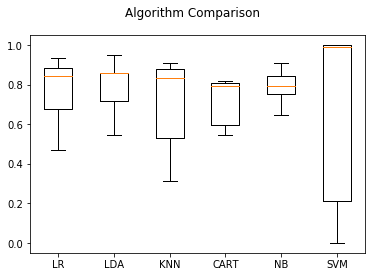

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.80001665001665</span>

{'name': 'LR', 'score': 0.7775890775890776}
{'name': 'LDA', 'score': 0.7944222444222444}
{'name': 'KNN', 'score': 0.7087912087912088}
{'name': 'CART', 'score': 0.7185148185148185}
{'name': 'NB', 'score': 0.80001665001665}
{'name': 'SVM', 'score': 0.6805361305361306}


**Training Section** for: 27 features

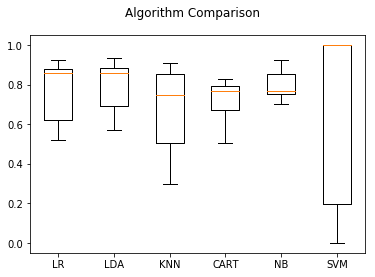

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.7974691974691974</span>

{'name': 'LR', 'score': 0.7775391275391275}
{'name': 'LDA', 'score': 0.7957375957375957}
{'name': 'KNN', 'score': 0.6766566766566766}
{'name': 'CART', 'score': 0.716050616050616}
{'name': 'NB', 'score': 0.7974691974691974}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 28 features

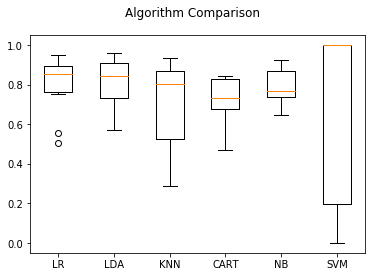

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.8048618048618048</span>

{'name': 'LR', 'score': 0.797086247086247}
{'name': 'LDA', 'score': 0.8048618048618048}
{'name': 'KNN', 'score': 0.7036796536796536}
{'name': 'CART', 'score': 0.7186313686313686}
{'name': 'NB', 'score': 0.7896936396936397}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 29 features

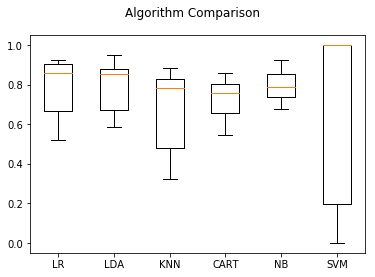

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7996170496170496</span>

{'name': 'LR', 'score': 0.7866300366300367}
{'name': 'LDA', 'score': 0.7996170496170496}
{'name': 'KNN', 'score': 0.6715284715284715}
{'name': 'CART', 'score': 0.7264402264402264}
{'name': 'NB', 'score': 0.7961538461538462}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 30 features

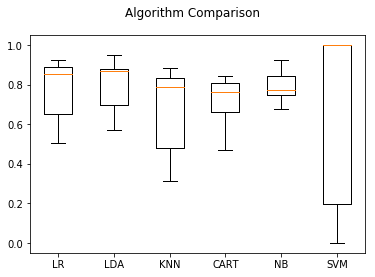

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7996336996336997</span>

{'name': 'LR', 'score': 0.7788877788877788}
{'name': 'LDA', 'score': 0.7996336996336997}
{'name': 'KNN', 'score': 0.6753579753579753}
{'name': 'CART', 'score': 0.7185647685647686}
{'name': 'NB', 'score': 0.791042291042291}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 31 features

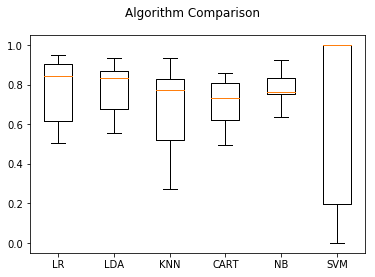

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.784132534132534</span>

{'name': 'LR', 'score': 0.7749583749583749}
{'name': 'LDA', 'score': 0.784132534132534}
{'name': 'KNN', 'score': 0.6844488844488844}
{'name': 'CART', 'score': 0.7081418581418581}
{'name': 'NB', 'score': 0.781934731934732}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 32 features

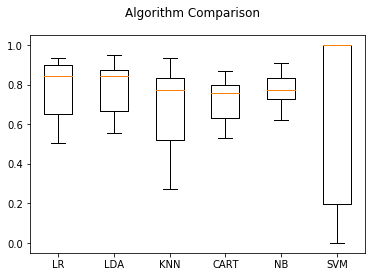

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7905427905427904</span>

{'name': 'LR', 'score': 0.7763236763236764}
{'name': 'LDA', 'score': 0.7905427905427904}
{'name': 'KNN', 'score': 0.687029637029637}
{'name': 'CART', 'score': 0.7198301698301698}
{'name': 'NB', 'score': 0.7793706293706293}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 33 features

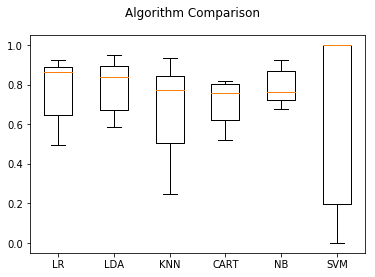

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7919247419247419</span>

{'name': 'LR', 'score': 0.7762903762903763}
{'name': 'LDA', 'score': 0.7919247419247419}
{'name': 'KNN', 'score': 0.6818015318015318}
{'name': 'CART', 'score': 0.7108225108225108}
{'name': 'NB', 'score': 0.7871461871461871}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 34 features

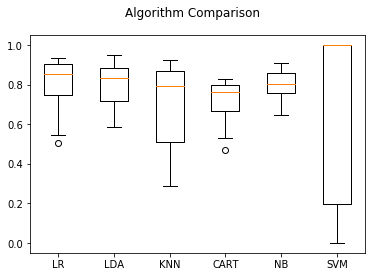

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.8010323010323012</span>

{'name': 'LR', 'score': 0.7932067932067931}
{'name': 'LDA', 'score': 0.8010323010323012}
{'name': 'KNN', 'score': 0.6946220446220446}
{'name': 'CART', 'score': 0.7121545121545122}
{'name': 'NB', 'score': 0.79998334998335}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 35 features

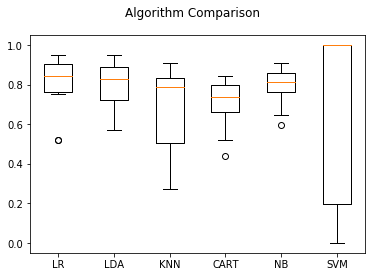

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.8048784548784548</span>

{'name': 'LR', 'score': 0.7945054945054946}
{'name': 'LDA', 'score': 0.8048784548784548}
{'name': 'KNN', 'score': 0.6869796869796869}
{'name': 'CART', 'score': 0.7069097569097569}
{'name': 'NB', 'score': 0.7922077922077921}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 36 features

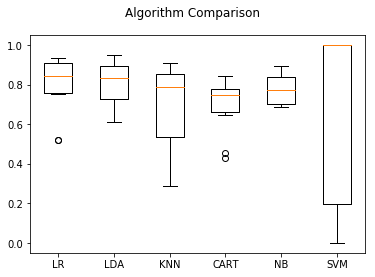

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.8049284049284049</span>

{'name': 'LR', 'score': 0.7932234432234433}
{'name': 'LDA', 'score': 0.8049284049284049}
{'name': 'KNN', 'score': 0.6960539460539461}
{'name': 'CART', 'score': 0.6965534465534465}
{'name': 'NB', 'score': 0.7794705294705294}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 37 features

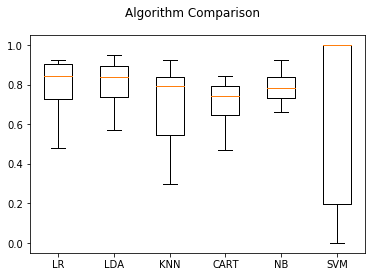

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7984348984348983</span>

{'name': 'LR', 'score': 0.7854478854478855}
{'name': 'LDA', 'score': 0.7984348984348983}
{'name': 'KNN', 'score': 0.6973526473526473}
{'name': 'CART', 'score': 0.6992007992007991}
{'name': 'NB', 'score': 0.790975690975691}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 38 features

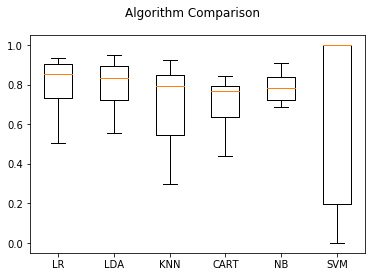

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7946053946053946</span>

{'name': 'LR', 'score': 0.7906093906093906}
{'name': 'LDA', 'score': 0.7946053946053946}
{'name': 'KNN', 'score': 0.6999167499167499}
{'name': 'CART', 'score': 0.7042957042957043}
{'name': 'NB', 'score': 0.7871461871461871}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 39 features

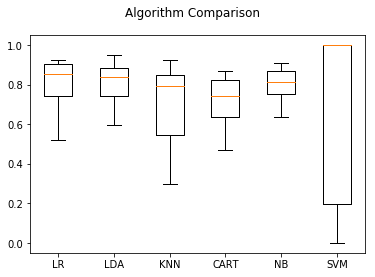

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.801065601065601</span>

{'name': 'LR', 'score': 0.7945054945054945}
{'name': 'LDA', 'score': 0.801065601065601}
{'name': 'KNN', 'score': 0.6986346986346986}
{'name': 'CART', 'score': 0.7145854145854147}
{'name': 'NB', 'score': 0.7974525474525475}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 40 features

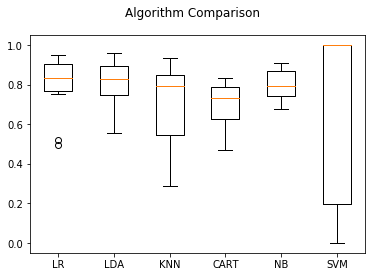

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7985014985014984</span>

{'name': 'LR', 'score': 0.7893439893439893}
{'name': 'LDA', 'score': 0.7985014985014984}
{'name': 'KNN', 'score': 0.7011988011988012}
{'name': 'CART', 'score': 0.6953712953712954}
{'name': 'NB', 'score': 0.7962037962037961}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 41 features

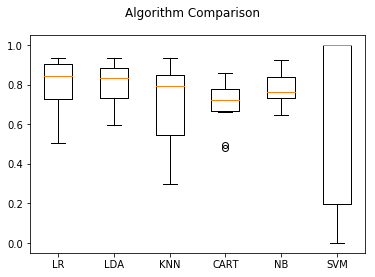

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7972194472194472</span>

{'name': 'LR', 'score': 0.7893273393273395}
{'name': 'LDA', 'score': 0.7972194472194472}
{'name': 'KNN', 'score': 0.6999167499167499}
{'name': 'CART', 'score': 0.6992174492174492}
{'name': 'NB', 'score': 0.781968031968032}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 42 features

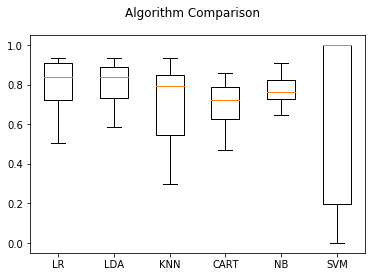

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7984848484848486</span>

{'name': 'LR', 'score': 0.7854645354645355}
{'name': 'LDA', 'score': 0.7984848484848486}
{'name': 'KNN', 'score': 0.7011988011988012}
{'name': 'CART', 'score': 0.6966200466200465}
{'name': 'NB', 'score': 0.7780885780885781}
{'name': 'SVM', 'score': 0.6779220779220779}


**Training Section** for: 43 features

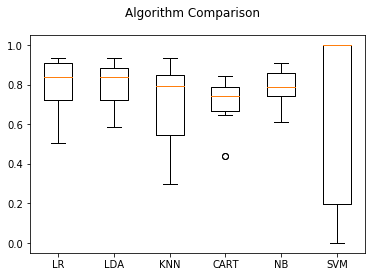

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.7971694971694971</span>

{'name': 'LR', 'score': 0.7867465867465868}
{'name': 'LDA', 'score': 0.7971694971694971}
{'name': 'KNN', 'score': 0.7011988011988012}
{'name': 'CART', 'score': 0.6965367965367966}
{'name': 'NB', 'score': 0.7871461871461871}
{'name': 'SVM', 'score': 0.6779220779220779}


In [17]:
    best_tr_results = []
    for X_train_mod in new_trains:
        # train the new shape
        printmd("**Training Section** for: " + str(X_train_mod.shape[-1]) + " features")
        train_resultes = train_the_data(X_train_mod,Y_train,models)
        best_tr = get_the_best(train_resultes)
        best_tr_results.append({"name":best_tr['name'],"score":best_tr['score'],"num_fetures":int(X_train_mod.shape[-1])})
        for model in train_resultes:
            print (model)

{'name': 'LDA', 'score': 0.6574425574425574, 'num_fetures': 1}
{'name': 'KNN', 'score': 0.7642191142191141, 'num_fetures': 2}
{'name': 'KNN', 'score': 0.7686147186147185, 'num_fetures': 3}
{'name': 'KNN', 'score': 0.7646520146520146, 'num_fetures': 4}
{'name': 'KNN', 'score': 0.7712121212121212, 'num_fetures': 5}
{'name': 'SVM', 'score': 0.7606560106560106, 'num_fetures': 6}
{'name': 'KNN', 'score': 0.7635697635697636, 'num_fetures': 7}
{'name': 'SVM', 'score': 0.7864635364635364, 'num_fetures': 8}
{'name': 'KNN', 'score': 0.7882450882450882, 'num_fetures': 9}
{'name': 'NB', 'score': 0.7882783882783884, 'num_fetures': 10}
{'name': 'SVM', 'score': 0.7955377955377955, 'num_fetures': 11}
{'name': 'LDA', 'score': 0.7840825840825841, 'num_fetures': 12}
{'name': 'LDA', 'score': 0.7853479853479854, 'num_fetures': 13}
{'name': 'NB', 'score': 0.7843989343989344, 'num_fetures': 14}
{'name': 'NB', 'score': 0.7947219447219447, 'num_fetures': 15}
{'name': 'NB', 'score': 0.7972693972693972, 'num_fet

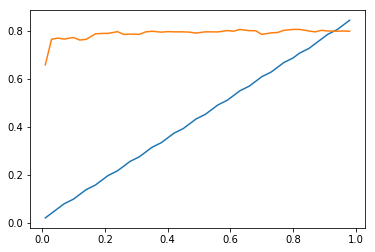

In [18]:
    for best in best_tr_results:
        print(best)
    plt.plot(new_range, np.column_stack((new_shapes_ratio, [rs['score'] for rs in best_tr_results])))

**Training Section** for: 418976 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


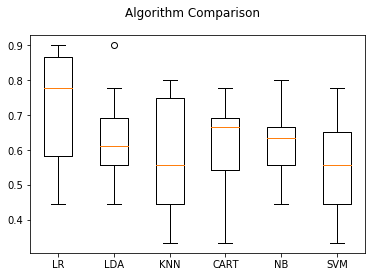

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444444</span>

{'name': 'LR', 'score': 0.7144444444444444}
{'name': 'LDA', 'score': 0.6266666666666667}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.62}
{'name': 'NB', 'score': 0.6177777777777778}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 300021 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


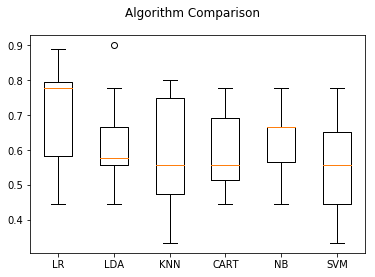

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6166666666666666}
{'name': 'KNN', 'score': 0.5822222222222222}
{'name': 'CART', 'score': 0.5977777777777777}
{'name': 'NB', 'score': 0.6211111111111112}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 249789 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


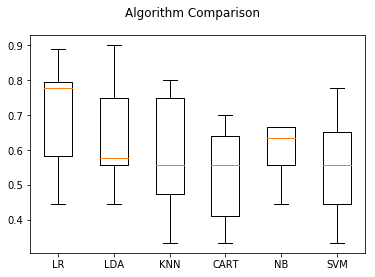

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6277777777777778}
{'name': 'KNN', 'score': 0.5933333333333334}
{'name': 'CART', 'score': 0.5211111111111111}
{'name': 'NB', 'score': 0.598888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 212518 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


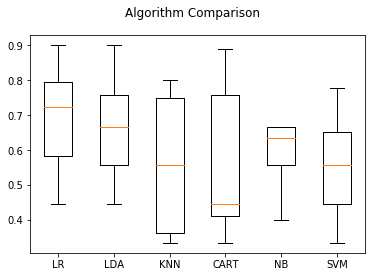

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6922222222222223</span>

{'name': 'LR', 'score': 0.6922222222222223}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.56}
{'name': 'CART', 'score': 0.5544444444444444}
{'name': 'NB', 'score': 0.5888888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 181350 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


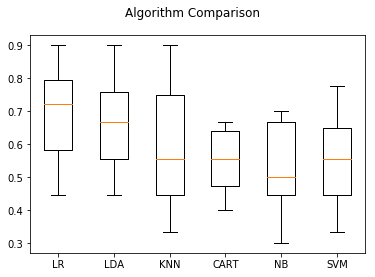

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.5811111111111111}
{'name': 'CART', 'score': 0.5466666666666666}
{'name': 'NB', 'score': 0.5333333333333334}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 153725 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


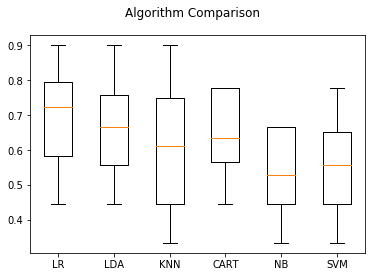

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6599999999999999}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6533333333333333}
{'name': 'NB', 'score': 0.5344444444444444}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 129439 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


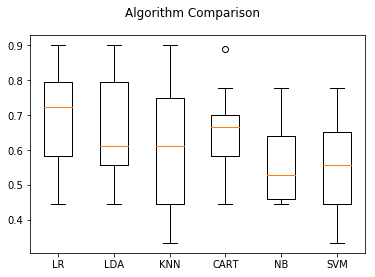

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6622222222222222}
{'name': 'NB', 'score': 0.5555555555555556}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 108368 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


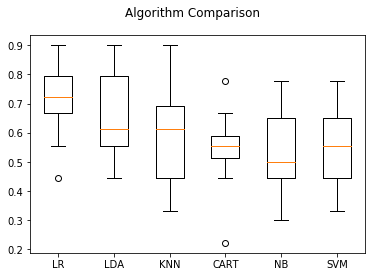

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444445</span>

{'name': 'LR', 'score': 0.7144444444444445}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.5433333333333333}
{'name': 'NB', 'score': 0.5344444444444445}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 90282 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [ ]:
#need to modify the test shape
    printmd("**Testing Section:**")
    test_results = test_the_data(X_train,Y_train,X_test,Y_test,models)
    best_ts = get_the_best(test_results)
    for model in test_results:
        print (model)


In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)